# Thermal Expansion Coefficient of Teflon

> [Return to Examples List](README.md)

This notebook demonstrates how to perform an analysis of TMA data to arrive at a thermal expansion coefficient curve.

## Load Experiment Data

First, let's load the experiment data from a JSON file and convert it into a Pandas `DataFrame`.

In [1]:
# This is just to ensure you have the data file, downloaded from TA's website
from file_downloader import download_files

filename = "TMA - Teflon Disk.json"
file_path = download_files(filename, "files/")[0]

In [2]:
from tadatakit.classes import Experiment

# Load the experiment data
experiment = Experiment.from_json(file_path)
df = experiment.get_dataframe("processed")

## Define a Smoothing Filter

Next, we define a smoothing filter to apply to our temperature and dimension data to remove noise.

In [3]:
import numpy as np

def gaussian_smooth(data_series, window_size=1000):
    """Smooth the data using a Gaussian filter."""
    def gaussian_kernel(size, sigma=1):
        """Generate a Gaussian kernel."""
        x = np.linspace(-size // 2, size // 2, size)
        kernel = np.exp(-0.5 * (x / sigma) ** 2)
        return kernel / kernel.sum()
    if window_size % 2 == 0:  # Ensure it's odd
        window_size += 1
    kernel = gaussian_kernel(window_size, sigma=window_size/10)
    padded_data = np.pad(data_series, (window_size // 2, window_size // 2), mode='reflect')
    smoothed_data = np.convolve(padded_data, kernel, mode='valid')
    return smoothed_data

## Calculate Temperature and Dimension Changes

Applying that smoothing filter to each of these columns allows us to establish a clearer thermal expansion coefficient (CTE).

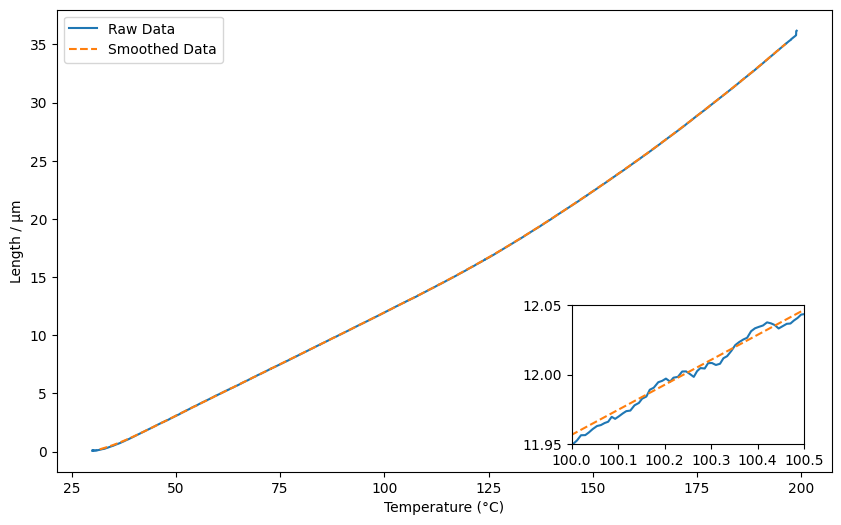

In [4]:
# Calculate the temperature change (ΔT)
df['Smoothed Temperature / °C'] = gaussian_smooth(df['Temperature / °C'].values, 4000)
df['Delta Temperature / °C'] = df['Smoothed Temperature / °C'].diff()

# Calculate the change in length (ΔL)
df['Smoothed Dimension Change / µm'] = gaussian_smooth(df['Dimension Change / µm'].values, 4000)
df['Delta Length / µm'] = df['Smoothed Dimension Change / µm'].diff()

# Plot them
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(10, 6))

# Main plot
plt.plot(df["Temperature / °C"], df["Dimension Change / µm"], label="Raw Data")
plt.plot(df["Smoothed Temperature / °C"], df["Smoothed Dimension Change / µm"], label="Smoothed Data", linestyle="dashed")
plt.legend()
plt.xlabel("Temperature (°C)")
plt.ylabel("Length / µm")

# Creating inset of the zoomed in area
x0, x1 = 100, 100.5
y0, y1 = 11.95, 12.05
ax_inset = inset_axes(plt.gca(), width="30%", height="30%", loc='lower right', borderpad=2)
ax_inset.plot(df["Temperature / °C"], df["Dimension Change / µm"])
ax_inset.plot(df["Smoothed Temperature / °C"], df["Smoothed Dimension Change / µm"], linestyle="dashed")
ax_inset.set_xlim([x0, x1])
ax_inset.set_ylim([y0, y1])

plt.show()

## Calculating Temperature Dependent CTE

Now we can use those smoothed values to calculate the temperature dependent CTE.

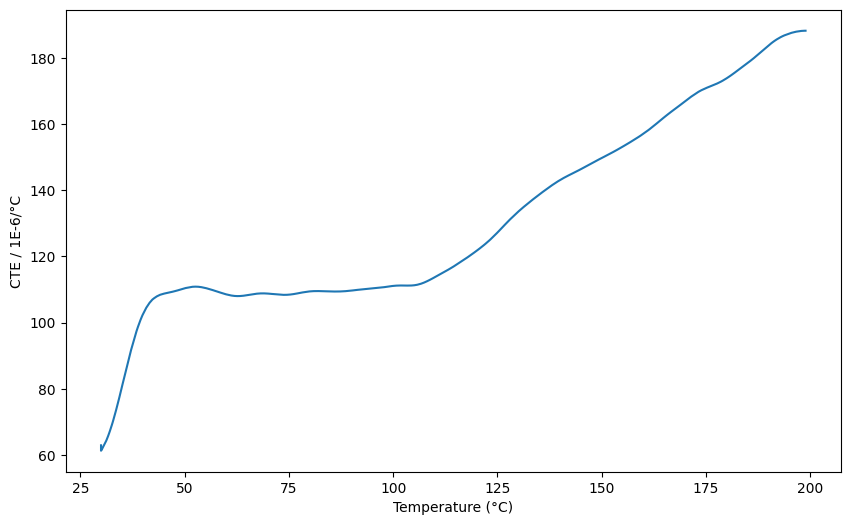

In [5]:
# Calculate the original length (L0)
L0 = df['Sample Length / µm'].iloc[0]

# Calculate CTE
df['CTE / 1/°C'] = df['Delta Length / µm'] / (L0 * df['Delta Temperature / °C'])

plt.figure(figsize=(10, 6))
plt.plot(
    df["Temperature / °C"],
    df['CTE / 1/°C'] * 1e6
)

plt.xlabel("Temperature (°C)")
plt.ylabel("CTE / 1E-6/°C")
plt.show()